## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble =r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
modver='HC1905'
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2017,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
rematch=False
if rematch==True:
    df1=et.loadDFO()
    df1.head()

In [3]:
if rematch==True:
    data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
    pickle.dump(data,open(f'/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFO_{start_date}_{end_date}_{modver}.pkl','wb'))
else:
    data=pickle.load(open(f'/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFO_{start_date}_{end_date}_{modver}.pkl','rb'))

###### reduce to 2015-2016 for clusters

In [4]:
ind=data.loc[data.dtUTC>=dt.datetime(2017,1,1)].index
data.drop(ind,inplace=True)

In [5]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [6]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

In [13]:
mod_chl_N=1.6
#mod_chl_N=2.0
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

##### Apply cluster information

In [8]:
cver = "BIO"
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cfile = {2013:"BIO_clno_5_2013_reass.pkl",2014:"BIO_clno_5_2014_reass.pkl", 
         2015: "BIO_clno_5_2015_reass.pkl", 2016: "BIO_clno_5_2016_reass.pkl"}
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
print('Cluster version is:', cver)
# papermill reads dictionary keys as strings, so add code to correct this
cfile2=dict()
for key,val in cfile.items():
    cfile2[int(key)]=val
cfile=cfile2
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))
cf=dict()
for iyear in cfile.keys():
    cf[iyear]=pickle.load(open(clusterD+cfile[iyear],'rb'))

def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

data['Cluster']=np.zeros(len(data))
for ir, row in data.iterrows():
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

Cluster version is: BIO


In [9]:
for el in cf.keys():
    print(np.unique(cf[el]))

[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]
[1. 2. 3. 4. 5.]


In [10]:
np.unique(data['Cluster'])

array([0., 1., 2., 3., 4., 5.])

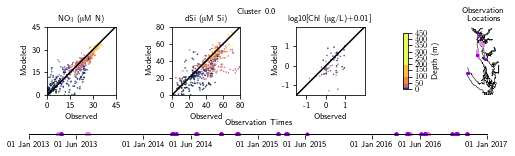

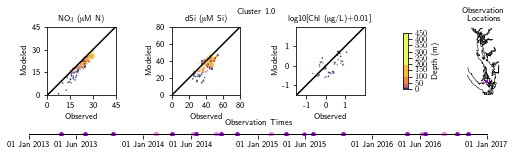

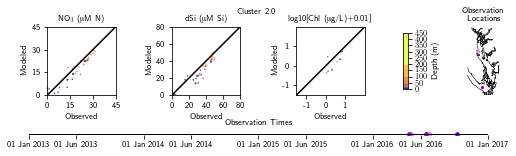

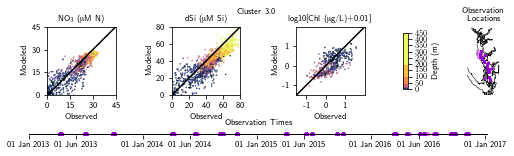

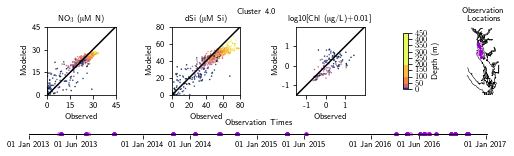

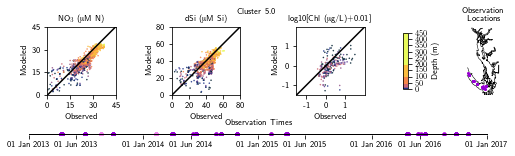

In [11]:
for ic in np.unique(data['Cluster']):
    bounds = np.array([0,5,10,15,20,40,100,200,450])
    norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    #pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')

    fig = plt.figure(figsize = (7.5,2.))
    gsv = gridspec.GridSpec(2,1,left=.08,right=.98,hspace=1,bottom=.1,top=.85,height_ratios=[4,.2])
    gs1=gridspec.GridSpecFromSubplotSpec(1,6,subplot_spec=gsv[0],wspace=.3,hspace=.34,
                                         width_ratios=[1,1,1,.05,.05,.6])
    axN = fig.add_subplot(gs1[0])
    axSi = fig.add_subplot(gs1[1])
    axChl = fig.add_subplot(gs1[2])
    axLmap = fig.add_subplot(gs1[-1])

    gscb = gridspec.GridSpecFromSubplotSpec(11,1,subplot_spec=gs1[3])
    axcb = fig.add_subplot(gscb[1:-1])

    axL=fig.add_subplot(gsv[1])

    axN.plot((0,45),(0,45),'k-')
    axSi.plot((0,80),(0,80),'k-')
    axChl.plot((-2,2),(-2,2),'k-')

    vm0=-150
    args={'marker':'.','s':1,'norm':norm}
    data2015=data.loc[(data.Cluster==ic)]
    ps=et.varvarScatter(axN,data2015,'N','mod_nitrate','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
    ps=et.varvarScatter(axSi,data2015,'Si','mod_silicon','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
    ps=et.varvarScatter(axChl,data2015,'l10_obsChl','l10_modChl','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

    cb=fig.colorbar(ps,cax=axcb,boundaries=np.linspace(0,450,46))
    cb.set_label('Depth (m)')
    #cb.set_ylim(0,450)

    ntick=np.arange(0,56,15)
    ntickl=[str(i) for i in ntick]
    for ax in (axN,):
        ax.set_xlim((0,45))
        ax.set_ylim((0,45))
        ax.set_xticks(ntick)
        ax.set_xticklabels(ntickl)
        ax.set_yticks(ntick)
        ax.set_yticklabels(ntickl)

    stick=np.arange(0,81,20)
    stickl=[str(i) for i in stick]
    for ax in (axSi,):
        ax.set_xlim((0,80))
        ax.set_ylim((0,80))
        ax.set_xticks(stick)
        ax.set_xticklabels(stickl)
        ax.set_yticks(stick)
        ax.set_yticklabels(stickl)

    ctick=np.arange(-1,2,1)
    ctickl=[str(i) for i in ctick]
    for ax in (axChl,):
        ax.set_xlim((-1.5,2))
        ax.set_ylim((-1.5,2))
        ax.set_xticks(ctick)
        ax.set_xticklabels(ctickl)
        ax.set_yticks(ctick)
        ax.set_yticklabels(ctickl)

    for ax in (axN,axSi,axChl,):
        ax.set_aspect(1, adjustable='box')
        #ax.set_xlabel('Observed')

    axN.set_ylabel('Modeled')
    axSi.set_ylabel('Modeled')
    axChl.set_ylabel('Modeled')
    axN.set_xlabel('Observed')
    axSi.set_xlabel('Observed')
    axChl.set_xlabel('Observed')


    axN.set_title('NO$_3$ ($\muup$M N)')
    axSi.set_title('dSi ($\muup$M Si)')
    axChl.set_title('log10[Chl ($\muup$g/L)+0.01]')

    #viz_tools.set_aspect(axLmap)
    for axLi in (axLmap,):
        axLi.set_aspect(1, adjustable='box')
        contour_lines = axLi.contour(blon,blat,bathyZ,[1e-5],
                    colors='black',zorder=2,linewidths=.5)
        axLi.set_xlim(-1.02,0.81)
        axLi.set_ylim(-1.5,1.8)
        axLi.axis('off')
    datanut2015=data2015.loc[(data2015.N>=0)|(data2015.Si>=0)]
    dataChl2015=data2015.loc[(data2015.Chlorophyll_Extracted>=0)]

    lons15,lats15=rotmap(datanut2015['Lon'], datanut2015['Lat'],lon0,lat0,theta)
    lons15chl,lats15chl=rotmap(dataChl2015['Lon'], dataChl2015['Lat'],lon0,lat0,theta)
    axLmap.plot(lons15,lats15, '.',color='violet',markersize=2)
    axLmap.plot(lons15chl,lats15chl, '.',color='darkviolet',markersize=2)
    axLmap.set_title('Observation\nLocations',fontsize=8)

    axL.set_title('Observation Times',fontsize=8)
    p1a,=axL.plot(datanut2015.dtUTC,np.zeros(np.shape(datanut2015.dtUTC)),'.',color='violet',markersize=6,label='2015')
    p1,=axL.plot(dataChl2015.dtUTC,np.zeros(np.shape(dataChl2015.dtUTC)),'.',color='darkviolet',markersize=6,label='2015')
    axL.set_yticks(());
    yearsFmt = mdates.DateFormatter('%d %b %Y')
    axL.xaxis.set_major_formatter(yearsFmt)

    axL.xaxis.set_ticks([dt.datetime(2013,1,1), dt.datetime(2013,6,1),
                         dt.datetime(2014,1,1), dt.datetime(2014,6,1),
                         dt.datetime(2015,1,1), dt.datetime(2015,6,1),
                         dt.datetime(2016,1,1), dt.datetime(2016,6,1),
                         dt.datetime(2017,1,1)])
    #labels=axL.xaxis.get_ticklabels()
    for tick in axL.get_xticklabels():
            #tick.set_rotation(90)
            tick.set_horizontalalignment('center')
    axL.set_ylim(-.1,.3)
    axLpos=axL.get_position()
    new = mpl.transforms.Bbox.from_bounds(axLpos.bounds[0],axLpos.bounds[1],axLpos.bounds[2]-.05,axLpos.bounds[3])
    axL.set_position(new)
    #axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-4])
    axL.set_frame_on(False)
    #axL.axes.get_yaxis().set_visible(False)
    #axL.axes.get_xaxis().set_visible(True)
    xmin, xmax = axL.get_xaxis().get_view_interval()
    ymin, ymax = axL.get_yaxis().get_view_interval()
    axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
    fig.suptitle('Cluster '+str(ic))
    fig.savefig(f'/data/eolson/results/MEOPAR/figs/eval/dfoEval{modver}_Cluster{int(ic)}.png',dpi=200,transparent=True)

In [15]:
print('All Chl:')
print('all:')
print('0= no cluster')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[(data.Cluster==icl),:],'Chlorophyll_Extracted','mod_Chl')

All Chl:
all:
0= no cluster
  N: 950
  bias: -1.4069565827272885
  RMSE: 4.040976848405701
  WSS: 0.5306956290367273
cluster 0
  N: 68
  bias: -0.8796319187970418
  RMSE: 2.451949020010316
  WSS: 0.6727670466206112
cluster 1
  N: 43
  bias: -1.3311679140634314
  RMSE: 2.478330397257175
  WSS: 0.6414901936821265
cluster 2
  N: 9
  bias: -1.419605740706125
  RMSE: 2.045555100981164
  WSS: 0.7801800275880982
cluster 3
  N: 475
  bias: -1.5367594973959813
  RMSE: 4.347413244226778
  WSS: 0.5555036607568502
cluster 4
  N: 133
  bias: -1.1685371322672171
  RMSE: 3.9802719035128034
  WSS: 0.3965768935692161
cluster 5
  N: 222
  bias: -1.4477518526441968
  RMSE: 4.092328384296318
  WSS: 0.4749222526947706


In [16]:
print('Surface Chl:')
print('all:')
print('0= no cluster')
et.printstats(data.loc[data.Z<10,:],'Chlorophyll_Extracted','mod_Chl')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[(data.Cluster==icl)&(data.Z<10),:],'Chlorophyll_Extracted','mod_Chl')

Surface Chl:
all:
0= no cluster
  N: 448
  bias: -1.7650823420837183
  RMSE: 5.1597652855800655
  WSS: 0.5031295473816424
cluster 0
  N: 32
  bias: -0.586355029858165
  RMSE: 2.821482903553643
  WSS: 0.6879700127681709
cluster 1
  N: 19
  bias: -1.0634836295639212
  RMSE: 2.344900856079811
  WSS: 0.7287748326331751
cluster 2
  N: 4
  bias: -1.753255829811096
  RMSE: 1.9810617351324484
  WSS: 0.7881194577772599
cluster 3
  N: 225
  bias: -2.122908444425795
  RMSE: 5.476600783013703
  WSS: 0.5315270124503486
cluster 4
  N: 65
  bias: -1.4795047339980423
  RMSE: 5.198989128309432
  WSS: 0.3431800478096362
cluster 5
  N: 103
  bias: -1.6597292069068867
  RMSE: 5.43888484418991
  WSS: 0.4444729712589637


In [17]:
print('All NO3:')
print('all:')
print('0= no cluster')
et.printstats(data,'N','mod_nitrate')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[(data.Cluster==icl),:],'N','mod_nitrate')

All NO3:
all:
0= no cluster
  N: 4732
  bias: -1.9456225389420467
  RMSE: 3.936833733282388
  WSS: 0.9397569973786136
cluster 0
  N: 582
  bias: -1.3142056220936276
  RMSE: 4.7365925039708365
  WSS: 0.9327052139591868
cluster 1
  N: 277
  bias: -2.8496943384301368
  RMSE: 3.384033345991773
  WSS: 0.8589571236788445
cluster 2
  N: 46
  bias: -1.7618750366957272
  RMSE: 3.3699581901174285
  WSS: 0.9648674452406951
cluster 3
  N: 2212
  bias: -2.126327268558331
  RMSE: 3.7144026445771674
  WSS: 0.9463849244079883
cluster 4
  N: 682
  bias: -0.9380498328282769
  RMSE: 3.6677379409719837
  WSS: 0.9520931498009404
cluster 5
  N: 933
  bias: -2.3882322558866065
  RMSE: 4.255357380997354
  WSS: 0.8965593941519093


In [18]:
print('All dSi:')
print('all:')
print('0= no cluster')
et.printstats(data,'Si','mod_silicon')
for icl in range(0,6):
    print('cluster',icl)
    et.printstats(data.loc[(data.Cluster==icl),:],'Si','mod_silicon')

All dSi:
all:
0= no cluster
  N: 4732
  bias: -6.1796957063371
  RMSE: 9.719739343904
  WSS: 0.8654243374547623
cluster 0
  N: 582
  bias: -6.876848311039183
  RMSE: 12.812597475743928
  WSS: 0.8194137508933672
cluster 1
  N: 277
  bias: -5.73315767267551
  RMSE: 7.3468557190259505
  WSS: 0.7206564429445312
cluster 2
  N: 46
  bias: -5.4708041165963515
  RMSE: 6.9805529131724
  WSS: 0.9236827670837162
cluster 3
  N: 2212
  bias: -6.991785534125825
  RMSE: 9.719630793030536
  WSS: 0.8663135545497569
cluster 4
  N: 682
  bias: -5.85630375356935
  RMSE: 9.133200220426348
  WSS: 0.913185806570674
cluster 5
  N: 933
  bias: -4.223391146031226
  RMSE: 8.565528903673297
  WSS: 0.7862887757483079
